# Summarizers Interface


This file instantiates all general parameters linked to model testing (and run the tests).

# MISC

## Import et chargement des méthodes

In [12]:
%matplotlib inline

%run Process_Summary.ipynb

%run Summary_Processes/Generic_Summarizer.ipynb

%run Summary_Processes/Baseline_Summay.ipynb
%run Summary_Processes/Random_Summary.ipynb

%run Summary_Processes/TextRank_Jaccard_Summary.ipynb
%run Summary_Processes/Embeddings_Summary.ipynb

%run Summary_Processes/TFIDF_Summary.ipynb

%run Summary_Processes/TextRank_TFIDF_Assym_Summary.ipynb
"""
%run Summary_Processes/Cluster_Summary.ipynb
%run Summary_Processes/Cluster_First_Summary.ipynb
"""
%run Summary_Processes/Sumy_Summary.ipynb

import os
import rouge
import random
import time
import math
from pprint import pprint as pp
import nltk
from nltk.corpus import stopwords
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/claire/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Display methods

In [13]:
def html_gen(docs, resumes) :
    for doc in set(docs.keys()).intersection(set(resumes[0].keys())) :
        
        #Head string with name of the file
        s = '<h2>'+doc+'</h2><p style="text-align:justify">'
        
        #Color Modifiers
        m1, m2, m3 = 0,0,0
        
        for i in range(len(docs[doc][0])) :
            k = len(resumes)
            
            #Color assignement
            m1 = 160 * (i in resumes[0][doc])
            if k-1 :
                m2 = 160 * (i in resumes[1][doc])
                if k-2 :
                    m3 = 160 * (i in resumes[2][doc])
            
            #Generating the sentence colored
            s += ('<span style="color:rgb('+str(m1)+','+str(m2)+','+str(m3)+')'
                +';background-color:rgb('+str(255)+',255,'+str(255)+')">'
                + docs[doc][0][i]
                +" </span>")
        
        #Display of the sentence
        display(HTML(s+"</p>"))

## Loading corpuses

### Corpus news

In [14]:
def generate_corpus_duc(method = 'nltk', len_sen = 10, over = 4, sampling = 1 ) :
    """
    Generate a corpus from the DUC dataset with documents and summaries.
    
    :param method:      String. Reference a tokenize method.
                        'nltk'    ->
                        'brutal'  ->
                        'overlap' ->
                        Default is nltk.
                        
    :param len_sen:     int. Number of words in a sentence.
                        Used by the 'brutal' and 'overlap' tokenizer.
                        
    :param over:        ???
                        Someting used by the 'overlap' tokenizer.
    
    :param sampling:    float. Threshold. Must be between 0.0 and 1.0
                        For each document in the data set, a random number
                        is drawn (between 0 and 1). If smaller than the
                        threshold, the document is kept in the final corpus.
                        Else, it's discarded.
                        
    :return:    docs: Dictionary mapping string to a string.
                      Maps a docset id + docid to a parsed and tokenized document.
                      'd061j/AP880911-0016' -> list(list of sentences unprocessed, list of cleaned sentences)
                golden_summaries: Dictionary mapping a string to a dictionary.
                      Maps a docset id + docid to multiple parsed and tokenized summaries.
                overall: Dictionary
    """
    # Used for generating the corpus from duc
    ## Preprocess des documents
    doc_folder = "../wdl/resume/docs/"
    doc_corpus = {}
    walker = os.walk(doc_folder)
    _ = next(walker)

    #Read all documents in subfolders  of the original folder
    for docset, _, docnames in walker :
        for docname in docnames :
            docpath = os.path.join(docset, docname)
            parsed_doc = parse_file(docpath, TextHandler())
            if parsed_doc :
                if random.random() < sampling:
                    doc_key = os.path.join(docset.split("/")[-1], docname)
                    doc_corpus[doc_key] = parsed_doc
    print("Loading done")
    
    #Sentence Tokenization of the corpus
    if method == 'nltk' :
        tokenized_docs = tokenizer_cleaner(doc_corpus)
    elif method == 'brutal' :
        tokenized_docs = brutal_tokenizer(doc_corpus, len_sen)
    elif method == 'overlap' :
        tokenized_docs = overlap_tokenizer(doc_corpus, len_sen, over)
    else :
        print("Method not accepted: %s" % method)
    
    #Cleaning part
    tokenized_docs = {k : tokenized_docs[k] for k in tokenized_docs if len(tokenized_docs[k][1])> 3}
    
    #Generating summaries
    summary_folder = "../wdl/resume/summaries/"
    summary_corpus = get_summaries(summary_folder)
    overall = summary_doc_linker(summary_corpus, tokenized_docs)
    gold_tokenized_summaries = {x : tokenizer_cleaner(summary_corpus[x]) for x in summary_corpus}
    return tokenized_docs, gold_tokenized_summaries, overall

### Corpus dmoz

In [15]:
#Generation corpus from the file
def generate_corpus(method = 'nltk', len_sen = 10, over = 4, sampling = 1 ) :
    """
    Generate a corpus from the dmzo dataset with documents and summaries.
    
    :param method:      String referencing a tokenize method.
                        'nltk'    ->
                        'brutal'  ->
                        'overlap' ->
                        Default is nltk.
                        
    :param len_sen:     Number of words in a sentence.
                        Used by the 'brutal' and 'overlap' tokenizer.
                        
    :param over:        ??? Someting used by the 'overlap' tokenizer.
    
    :param sampling:    Threshold. Float. Must be between 0.0 and 1.0
                        For each document in the data set, a random number
                        is drawn (between 0 and 1). If smaller than the
                        threshold, the document is kept in the final corpus.
                        Else, it's discarded.
                        
    :return:    docs: Dictionary mapping string to a string.
                      Maps a docset + docid to a parsed and tokenized document.
                golden_summaries: Dictionary mapping a string to a dictionary.
                      Maps a docset + docid to multiple parsed and tokenized summaries.
                overall: Dictionary
    """    
    corpus = {}
    with open("../wdl/resume/dmoz-fr-content.tsv") as file :
        line = file.readline()
        i = 0
        while line :
            key, data = line[:-1].split("\t")
            if random.random() < sampling:
                corpus[key] = data
            line = file.readline()
            i+=1

    print("Loading done")

    #Sentence tokenizing part
    if method == 'nltk' :
        docs = tokenizer_cleaner(corpus)
    elif method == 'brutal' :
        docs = brutal_tokenizer(corpus, len_sen)
    elif method == 'overlap' :
        docs = overlap_tokenizer(corpus, len_sen, over)
    else :
        print("Method not accepted")

    #Cleaning part
    docs = {k : docs[k] for k in docs if len(docs[k][1])> 3}

    #Summaries generator
    summary_corpus = {}
    #stops = set(stopwords.words('french'))
    stops = set()
    with open("../wdl/resume/dmoz-fr-description") as file :
        line = file.readline()
        i = 0
        while line :
            key, data = line[:-1].split("\t")
            datac = " ".join(set(data.split()) - stops)
            summary_corpus[key] = { "m" : datac }
            line = file.readline()
            i+=1
    
    gold_tokenized_summaries = {x : tokenizer_cleaner(summary_corpus[x]) for x in summary_corpus }
    gold_tokenized_summaries = {x : gold_tokenized_summaries[x] for x in gold_tokenized_summaries
                               if all(len(gold_tokenized_summaries[x][a][1])>0 for a in gold_tokenized_summaries[x])
                               
                               }

    #Linking summaries and corpus
    overall = {x : "" for x in set(docs.keys()).intersection(gold_tokenized_summaries.keys())}
    
    return docs, gold_tokenized_summaries, overall

## Summarizers Initialization

Define the _option_ variable which a list of summarization processes to test.

* Each summarization process is instantiaded with its options.
* A summarization process is a model and its routines.
* Models and their routines are defined in the [Summary_Processes folder](http://localhost:8888/tree/web-summary/Summary_Processes).

In [16]:
print("Running summarizers")
import math
#List of all options 
def const_1(x):
    return 1
def const_2(x):
    return 2
emb_fol = "../wdl/clustering/crawl-dmoz-fr/docWords/"
option = ([#Baseline_process(),
          #Random_process(),
          #TextRank_Jaccard_process(1, 0, weighted = False, method = "tr", lsanbcompfun = math.log, diag = "none"),
          #TextRank_Jaccard_process(1, 0, weighted = False, method = "lsa", lsanbcompfun = math.log, diag = "before"),
          #TextRank_TFIDF_Summarizer_Assym_process(1, 0, weighted = False),
          #TextRank_TFIDF_Summarizer_Assym_process(1, 0, weighted = False,
          #                                        method = "lsa", lsanbcompfun = math.log, diag = "before"),
          # Embeddings_process("wordsembeddings.npy", "wordslist.txt", "words.df.csv" , "docs-count.txt", 
          #                   emb_fol, weighted = False, exponentiation = 4, ldanbcompfun = const_1, bias = 0.0),
          #Embeddings_process("wordsembeddings.npy", "wordslist.txt", "words.df.csv" , "docs-count.txt", 
          #                   emb_fol, weighted = False, exponentiation = 4,
          #                   method = "lsa", ldanbcompfun = const_1),
         ]
         + [TextRank_TFIDF_Summarizer_Assym_process(1, 0.25*i, weighted = False, method = method, lsanbcompfun = fun, diag = diag, bias = 0.5*bias)
              for diag in ["none","before"] for i in range(1) for method in ["lsa"] for bias in [3] for fun in [const_1] ]
         #+ [ TextRank_Jaccard_process(1, 0.25*i, weighted = False, method = m, lsanbcompfun = const_1, diag = diag, bias = 0.5*bias)
         #     for i in range(1) for diag in ("none", "before") for m in ("tr", "lsa") for bias in [3]] 
         #+ [TextRank_TFIDF_Summarizer_Assym_process(1, 0.25*i, weighted = False, method = method, lsanbcompfun = fun, diag = diag, bias = 0.5*bias)
         #     for diag in ["none","before"] for i in range(1) for method in ["lsa","tr"] for bias in [3] for fun in [const_1] ]
          #+ [Embeddings_process("wordsembeddings.npy", "wordslist.txt", "words.df.csv" , "docs-count.txt", 
         #                    emb_fol, a = 1, b = 0.25*i, weighted = False, method = method, lsanbcompfun = fun, diag = diag, bias = 0.5*bias)
         #     for diag in ["none","before"] for i in range(1) for method in ["lsa","tr"] for bias in [3] for fun in [const_1] ]
         )


#List of options for sumy
folder = "../wdl/resume/docs/"
summy_option = [ Sumy_process(mode, folder, "french", nb_sent = 2) for mode in ["text_rank"]]
#, "sum_basic", "kl", "luhn", "lsa", "lex_rank"]]
#summy_option = []

Running summarizers


In [17]:
# Defines an empty dictionary in wich median ROUGE L scores will be stored.

evaluator = rouge.Rouge(metrics=['rouge-1'],)
rouge_score = defaultdict(dict)

## Summarizers testing process

* Load stop words (optional)
* Cut the corpus (is this tokenization ?)
* Generate corpuses
* Mystic code

In [18]:
import pandas as pd

SCORE_DIR = "../scores"
SCORE_FILE = os.path.join(SCORE_DIR, "best_summarizers_scores.csv")
COLS_NAME = ["summarizer_name", "exec_time", "avg_rl_f", "avg_rl_p", "avg_rl_r", "text_cut", "sampling_size"]

def save_summarizer_score(summarizer_name, time, average_score, text_cut, sampling_size, clear_prev=False):
    """
    Saves the avergae rouge score of a summarizer.
    
    Creates a file named summarizers_scores.csv and adds the different variables for the model.
    CSV header is defined as follow: summarizer_name,exec_time,avg_score,sampling_size
    
    :param summarizer_name:    Name of the summarizer model.
    :param time:               Time the model took to create the summaries.
    :param average_scores:     The average rouge-l score of the model.
    :param sampling_size:      The % of document selected.
    :param clear_prev:         Wether previous entries for this model should be deleted.
    """
    
    # creates the directory for scores if it doesn't exists.
    if not os.path.exists(SCORE_DIR):
        os.makedirs(SCORE_DIR)
        
    # Prepare the row to save in the data frame
    new_row = [summarizer_name, time, average_score["f"], average_score["p"], average_score["r"],
               str(text_cut), sampling_size]
    
    # Loads the csv file if it exists
    if os.path.exists(SCORE_FILE):
        df = pd.read_csv(SCORE_FILE, index_col=0)
        print(df.columns)
        df = df.append(dict(zip(COLS_NAME, new_row)), ignore_index=True)
    else:
        df = pd.DataFrame(np.array([new_row]), columns = COLS_NAME)
    df.to_csv(SCORE_FILE)

In [ ]:
len_summary = 20

def run_summaries(option, len_summary, rouge_score, corpus = "dmoz", language = "french", sampling = 1):
    """
    :param option:       List of summarizer process to be tested.
    :param len_summary:  Number of words forming the summary.
    :param rouge_score:  Empty dictionary in wich ROUGE L median scores will be stored.
    :param corpus:       String to indentify the corpus to use. (Not sure of that one)
    :param language:     String to indicate the language.
                         If set, allows to use the stop words of the given language.
                         Default value is "french".
    :param sampling:     Threshold value for document selection.
    """
    
    # list of hypotetic / predicted summaries generated with a summarizer
    pred_sum = []
    k = 0
    
    # Loads stop words for a given language if set.
    stops = set() if language is None else set(stopwords.words(language))
    
    # Choose the 'cut' for the corpuses.
    # Choix du découpage des corpus
    
    #for gen in [('brutal', 10)]:
    for gen in [('brutal',i*5) for i in range(1,4)] + [('overlap', i*5, i*2) for i in range(1,4)]+[('nltk',)] :
        print("\n####"+"-".join([str(x) for x in gen])+"####")
        
        # Corpus generation.
        if corpus == "dmoz" :
            docs, gold_tokenized_summaries, overall = generate_corpus(*gen, sampling = sampling)
        else :
            docs, gold_tokenized_summaries, overall  = generate_corpus_duc(*gen, sampling = sampling)
        
        
        for summarizer in option :
            
            # Creation of hypotetic summaries with the summarizer being tested.
            print("\n"+summarizer.__name__)
            s = time.time()
            pred_sum.append(doc_summarizer(docs, summarizer, len_summary, 0 if len(gen) < 3 else gen[2]))
            e = time.time()
            print("\nTime :", "{:.2f}s".format(e-s))
            print("Summary done")
            
            # Création des phrases
            all_hypothesis = []
            all_references = []
            # For each word in our documents and in 
            for ref in set(overall.keys()).intersection(docs.keys()) :
                if len(gen)>2 :

                    pred_sum_words = set()
                    sen = ""
                    for sen_id in pred_sum[k][ref]:
                        segment = docs[ref][1][sen_id].split()
                        for i in range(sen_id*gen[2], sen_id*gen[2] + gen[1]) :
                            if i in pred_sum_words :
                                pass
                            else :
                                pred_sum_words.add(i)
                                sen += " " + segment[i-sen_id*gen[2]]
                                if len(pred_sum_words) == len_summary :
                                    break
                        else :
                            continue
                        break

                    hypothesis = sen

                else :
                    hypothesis = join_and_cut_at([docs[ref][1][sen_id] for sen_id in pred_sum[k][ref]],
                                                          len_summary, stops)
                for anot in gold_tokenized_summaries[ref] :
                    all_hypothesis.append(hypothesis)
                    all_references.append(join_and_cut_at(gold_tokenized_summaries[ref][anot][1], len_summary, stops))
            print("Rouge preprocess done")

            #Calcul des scores rouges.
            under = [x["rouge-1"] for x in evaluator.get_scores(all_hypothesis, all_references)]
            med = { k : sum(t[k] for t in under)/len(under) for k in under[0] }
            rouge_score["-".join([str(x) for x in gen])][summarizer.__name__] = {"rouge-1" : med}
            print("Rouge done : "+ str(med))
            save_summarizer_score(summarizer.__name__, "{:.2f}s".format(e-s), med, "-".join([str(x) for x in gen]), sampling)
            
            k+=1
    #Renvoies les résumés.
    return pred_sum

resumes = run_summaries(option, len_summary, rouge_score, language=None)


####brutal-5####
Loading done

LSA_TFIDF_Summarizer_Assym_process(1,0.0,unweighted,none, 1.5 )
Preprocess done


### Sumy

Testing of the [sumy library](#https://pypi.org/project/sumy/).

Why is it not done with the other summarizer processes ? God only knows.

In [ ]:
sumy_summaries = []

# Loads stop words for a given language if set.
stops = set()

# Choose the 'cut' for the corpuses.
# Choix du découpage des corpus
for gen in [('brutal',i*5) for i in range(1,4)]+[('overlap', i*5, i*2) for i in range(1,4)]+[('nltk',)] :
    print("\n####"+"-".join([str(x) for x in gen])+"####")

docs, gold_tokenized_summaries, overall = generate_corpus(*gen, sampling = 1)
for summarizer in summy_option :
    print("\n"+summarizer.__name__)
    d = {}
    i = 0
    l = len(docs)
    for ref in docs.keys() :
        i+=1
        d[ref] = summarizer.summarize(ref, docs, True)
        print("\r{:.2%}".format(i/l),end = " ")
    sumy_summaries.append(d)
    
    print("\nSummary done")
    all_hypothesis = []
    all_references = []
    for ref in overall.keys() :
        hypothesis = [ "\n".join(sumy_summaries[-1][ref])] 
        references = [[ "\n".join(gold_tokenized_summaries[ref][ano][0]) for ano in gold_tokenized_summaries[ref] ]]
        all_hypothesis += hypothesis
        all_references += references
    rouge_score[option.__name__] = evaluator.get_scores(all_hypothesis, all_references)

## Display some results

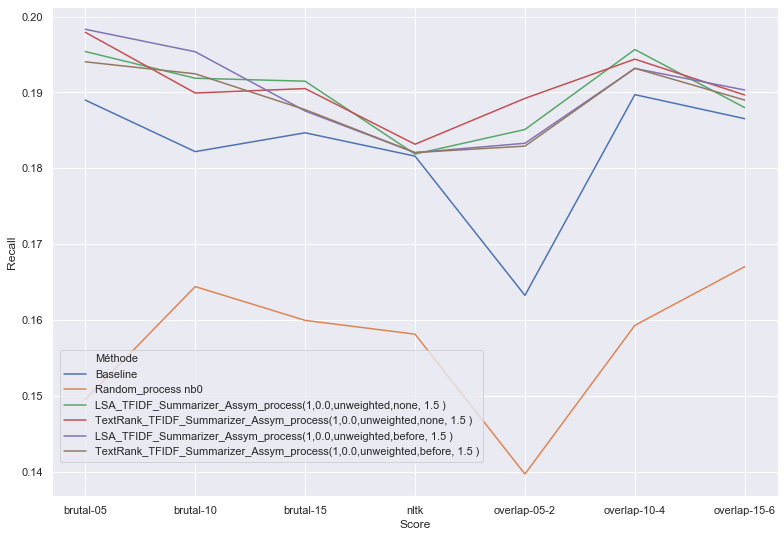

Rappel,brutal-05,brutal-10,brutal-15,nltk,overlap-05-2,overlap-10-4,overlap-15-6
"LSA_TFIDF_Summarizer_Assym_process(1,0.0,unweighted,before, 1.5 )",0.198321,0.195363,0.187556,0.182067,0.1833,0.193158,0.190321
"TextRank_TFIDF_Summarizer_Assym_process(1,0.0,unweighted,none, 1.5 )",0.197926,0.189926,0.190509,0.183171,0.189216,0.194388,0.18966
"LSA_TFIDF_Summarizer_Assym_process(1,0.0,unweighted,none, 1.5 )",0.195391,0.19187,0.191482,0.181878,0.185116,0.195656,0.187998
"TextRank_TFIDF_Summarizer_Assym_process(1,0.0,unweighted,before, 1.5 )",0.194037,0.192456,0.187731,0.182077,0.182923,0.193188,0.188995
Baseline,0.188992,0.182199,0.184682,0.181607,0.163253,0.189708,0.186544
Random_process nb0,0.149532,0.164413,0.159959,0.158144,0.139704,0.159302,0.167037


In [10]:
sns.set(rc={'figure.figsize':(13,9)})
    
#Used to turn the dictionary into a usable dataframe.
rowsR = []
for g in rouge_score :
    for m in rouge_score[g] :
        for s in rouge_score[g][m] :
            rowsR.append({"Méthode" : m, "Score" : g, "Recall" : rouge_score[g][m][s]['r']})
replacement = (["brutal-5", "overlap-5-2"],["brutal-05", "overlap-05-2"])
dataR = pd.DataFrame(rowsR, columns = ["Méthode","Score", "Recall"]).replace(*replacement)

#For showing datas in a graph
sns.lineplot(data=dataR, x="Score", y="Recall",hue="Méthode" )
plt.legend(bbox_to_anchor=(0.01, 0.3), loc=2, borderaxespad=0.)
plt.show()


dfR = pd.DataFrame(index = sorted(set(dataR["Méthode"])),
                   columns = sorted(set(dataR["Score"]))).rename_axis("Rappel", axis="columns")
for r in dataR.iterrows()  :
    dfR.at[r[1]["Méthode"], r[1]["Score"]] = r[1]["Recall"]
from IPython.display import display
display(dfR.sort_values(['brutal-05'],ascending=False))